# Dimensionality Reduction

The sheer size of data in the modern age is not only a challenge for computer hardware but also a main bottleneck for the performance of many machine learning algorithms. The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense. In a nutshell, this is what PCA is all about: Finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.

## Principal Components Analysis

Often, the desired goal is to reduce the dimensions of a **d**-dimensional dataset by projecting it onto a (**k**)-dimensional subspace (where **k** < **d**) in order to increase the computational efficiency while retaining most of the information. An important question is “what is the size of **k** that represents the data ‘well’?”

Later, we will compute eigenvectors (the principal components) of a dataset and collect them in a projection matrix. Each of those eigenvectors is associated with an eigenvalue which can be interpreted as the “length” or “magnitude” of the corresponding eigenvector. If some eigenvalues have a significantly larger magnitude than others that the reduction of the dataset via PCA onto a smaller dimensional subspace by dropping the “less informative” eigenpairs is reasonable.

## Exercise 1 - Explore the Iris Data Set

[Original Data](https://archive.ics.uci.edu/ml/datasets/Iris). [Background Info](https://en.wikipedia.org/wiki/Iris_flower_data_set).

In [6]:
import pandas as pd

iris = pd.read_csv(filepath_or_buffer="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
                   header=None, sep=',')
iris.columns=['sep_len', 'sep_wid', 'pet_len', 'pet_wid', 'species']
iris.isnull().values.any()

False

In [7]:
iris.head()

,sep_len,sep_wid,pet_len,pet_wid,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


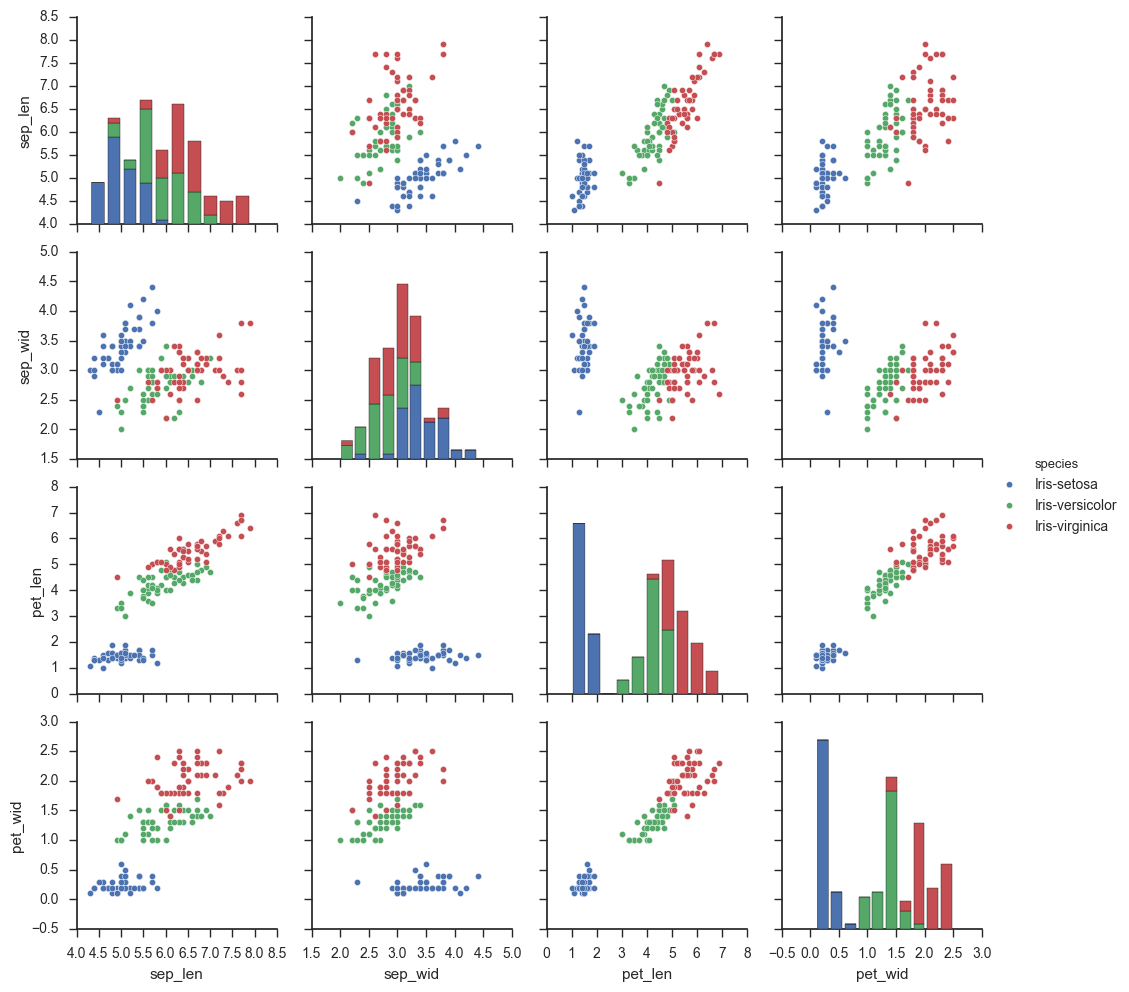

In [13]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
%matplotlib inline

pair_graph = sns.pairplot(iris, hue='species')

Looks like a high correlation between petal width and petal length.

In [21]:
# Another way to look at the data
X = iris.ix[:,0:4].values # first four column values
y = iris.ix[:,4].values # last column values

In [23]:
X[y=='Iris-setosa', 1]

array([ 3.5,  3. ,  3.2,  3.1,  3.6,  3.9,  3.4,  3.4,  2.9,  3.1,  3.7,
        3.4,  3. ,  3. ,  4. ,  4.4,  3.9,  3.5,  3.8,  3.8,  3.4,  3.7,
        3.6,  3.3,  3.4,  3. ,  3.4,  3.5,  3.4,  3.2,  3.1,  3.4,  4.1,
        4.2,  3.1,  3.2,  3.5,  3.1,  3. ,  3.4,  3.5,  2.3,  3.2,  3.5,
        3.8,  3. ,  3.8,  3.2,  3.7,  3.3])

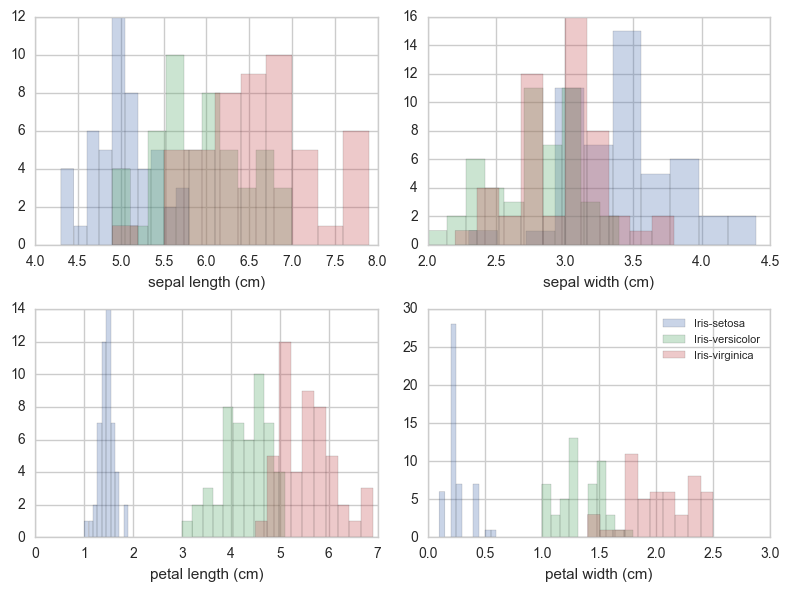

In [26]:
# visualization through histograms
import matplotlib.pyplot as plt
import numpy as np
import math

label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virginica'}

feature_dict = {0: 'sepal length (cm)',
                1: 'sepal width (cm)',
                2: 'petal length (cm)',
                3: 'petal width (cm)'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8,6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt], # plotting the different values for each X variable under each species
                     label=lab,
                     bins=10,
                     alpha=0.3)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)
    
    plt.tight_layout()
    plt.show()
            

## Exercise 2 - Build a PCA Class

General Steps for PCA ([walkthrough in R if you get stuck](http://alexhwoods.com/pca/)):
1. Standardize the data.
2. Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.
3. Sort eigenvalues in descending order and choose the **k** eigenvectors that correspond to the **k** largest eigenvalues where **k** is the number of dimensions of the new feature subspace (**k ≤ d**).
4. Construct the projection matrix **W** from the selected **k** eigenvectors.
5. Transform the original dataset **X** via **W** to obtain a **k**-dimensional feature subspace **Y**.

The class should be able to:
- Calculate the principal components with an optional parameter
- Project onto a 2-dimensional feature space

In [37]:
# PCA Class
from sklearn.preprocessing import StandardScaler # standardize to unit scale (mean 0 , var 1)

class PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        
    def standardize(self, data):
        return StandardScaler().fit_transform(data)
    
    def covariance(self, data): # obtain covariance matrix
        return np.cov(data.T)
    
    def eigendecomp(self, data): # eigen vectors and eigen values
        eig_vals, eig_vecs = np.linalg.eig(data)
        return eig_vals, eig_vecs
    
    # deciding which eigenvector(s) can be dropped without losing too much info
    # lowest eigenvalues bear least info about data distribution
    # rank eigenvalues descending
    def select_components(self, vals, vecs):
        # list of (eig_vals and eig_vecs tuples)
        eig_pairs = [(np.abs(vals[i]), vecs[:,i]) for i in range(len(vals))]
        # sort the tuples from high to low
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        
        if self.n_components == None:
            self.components = eig_pairs
        else:
            self.components = eig_pairs[:n_components]
            
    # depending on number of principal components we can see how much more variance is explained
    # by marginally adding another PC
    def explained_variance(self, vals):
        total_variance = sum(vals)
        var_exp = [(i / total_variance) * 100 for i in sorted(vals, reverse=True)]
        cum_var_exp = np.cumsum(var_exp)
        
        self.explained_variance = var_exp
        self.cumulative_variance = cum_var_exp
        
    def fit(self, data):
        standardized_data = self.standardize(data)
        covariance_matrix = self.covariance(standardized_data)
        
        eig_vals, eig_vecs = self.eigendecomp(covariance_matrix)
        
        self.select_components(eig_vals, eig_vecs)
        self.explained_variance(eig_vals)
        
    def transform(self, data):
        # 4 x 2 matrix
        projection_matrix = np.hstack((self.components[0][1].reshape(4,1),
                                       self.components[1][1].reshape(4,1)))
            
        standardized_data = self.standardize(data)
        Y = standardized_data.dot(projection_matrix)
        return Y

## Exercise 3 - Try it out on the Iris Data Set

1. Plot the individual explained variance vs. cumulative explained variance.
2. Plot the Iris data set on the new 2-dimensional feature subspace.


In [38]:
pca = PCA()

In [39]:
pca.fit(X)

In [42]:
print('Components: ', pca.components)

Components:  [(2.9303537755893174, array([ 0.52237162, -0.26335492,  0.58125401,  0.56561105])), (0.92740362151734212, array([-0.37231836, -0.92555649, -0.02109478, -0.06541577])), (0.14834222648163944, array([-0.72101681,  0.24203288,  0.14089226,  0.6338014 ])), (0.020746013995595943, array([ 0.26199559, -0.12413481, -0.80115427,  0.52354627]))]


In [43]:
print('Explained Variance: ', pca.explained_variance)

Explained Variance:  [72.770452093801339, 23.03052326768065, 3.6838319576273775, 0.5151926808906323]


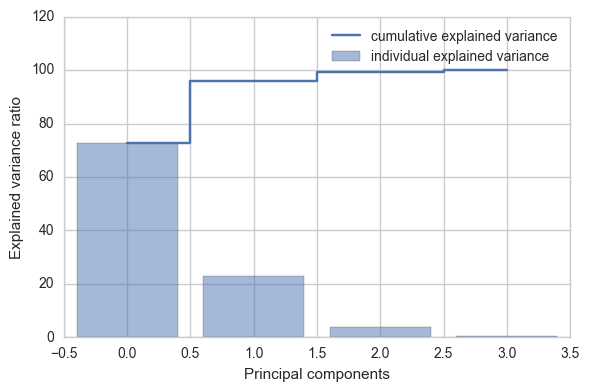

In [52]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.bar(range(4), pca.explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), pca.cumulative_variance, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.ylim(0,120)
    plt.show()

In [55]:
Y = pca.transform(X)

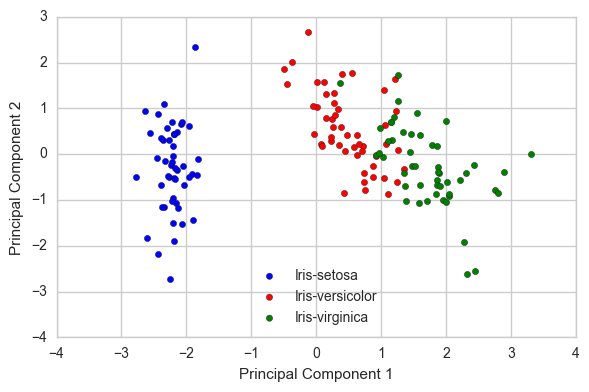

In [56]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()

## Exercise 4 - Check via Scikit-Learn

This exercise was purely academic. You will always use an optimized version of PCA in practice.

In [53]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)

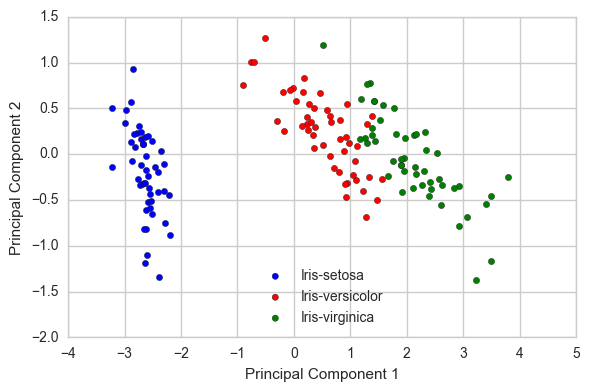

In [54]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()